# Federated learning: how to encapsulate a custom model in Sherpa.FL

The present notebook tackles the problem encapsulating a custom machine learning model into *Sherpa.FL* for experimentation in the federated configuration. 
In this case, we will create a learning model from scratch and show how to make it interact with the *Sherpa.FL* framework. 
For simplicity, a two-features case of linear regression is considered, since explicit formula for the minimization of the object function is available (see [Introduction to statistical learning](http://faculty.marshall.usc.edu/gareth-james/ISL/) Section 3.1).
For completeness, we assess the *accuracy* in a federated learning context, and we address the *privacy level needed* in terms of sampling the sensitivity of our model for application of Differential Privacy. 
For a more extensive use of differential privacy with Federated Learning, see also notebooks on [Linear Regression](/.federated_models_linear_regression.ipynb) and [K-means clustering](./federated_models_k_means.ipynb).
Also, see the notebook on [Regression using Keras](./federated_models_regression_deeplearning.ipynb), where a neural network model is used to perform regression. 

## Model definition
In order to make our model interact with the Federated Learning platform we will simply need to define:
1. How to load the data;
2. The model.

In the following, each step is described for the case of a 2D linear regression model. 

**How to load the data**\
A method that returns train, test and validation data need to be provided, wrapping it in the class `data_base`.
Typically, existing data is used. 
However, in this example a series of 2D points is created for simplicity:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shfl
from shfl.data_base.data_base import LabeledDatabase

def generate_data():
    size_data = 100
    beta0 = 10
    beta1 = 2
    scale = 10

    data = np.random.randint(low = 0, high=100, size=size_data, dtype='l')
    labels = beta0 + beta1*data + np.random.normal(loc=0.0, scale=scale, size=len(data))
    
    return data, labels

# Create database:
data, labels = generate_data()
database = LabeledDatabase(data, labels)
train_data, train_labels, test_data, test_labels = database.load_data()
print(len(train_data))
print(len(test_data))

80
20


**Define the model** <br/>
Now we just need to define the model, which needs to be wrapped in the class `TrainableModel`. 
Abstract methods from class `TrainableModel` need to be defined, i.e. we must provide methods for `train`, `predict`, `evaluate`, `get_parameters` and `set_parameters`. 
For the `evaluate` method we choose the Root Mean Squared and the Mean Absolute Percentage errors as performance metrics.
A possible implementation is the following:

In [9]:
from shfl.model import TrainableModel

class LinearRegression2D(TrainableModel):
    
    def __init__(self, beta0 = 0.0, beta1=0.0):
        self._beta0 = beta0
        self._beta1 = beta1
        
    def train(self, data, labels):
        """
        In the case of 2D linear regression, a closed formula can be used.
        """
        data_mean = np.mean(data)
        labels_mean = np.mean(labels)
        beta1 = np.sum( np.multiply((data-data_mean), (labels-labels_mean)) ) / np.sum( np.square((data-data_mean)) )
        beta0 = labels_mean - beta1*data_mean
        self._beta0 = beta0
        self._beta1 = beta1
        
    def predict(self, data):
        y_predicted = self._beta0 + self._beta1 * data
        
        return(y_predicted)
    
    def evaluate(self, data, labels):
        """
        Add here all the metrics to evaluate the performance. 
        """
        prediction = self.predict(data)
        error = np.square(labels - prediction)
        RMSE = np.sqrt(error.mean())
        MAPE = np.abs(np.divide(error, labels)).mean() 
        
        return RMSE, MAPE 

    def get_model_params(self):
        return np.asarray((self._beta0, self._beta1))
    
    def set_model_params(self, params):
        self._beta0 = params[0]
        self._beta1 = params[1]

We can graphically check that our implementation is correct by training the model on the centralized data:

Regression coefficients: (8.80154087365186, 2.0132506660859613)
Performance metrics on test data: (9.912575251488226, 1.0194442237813102)


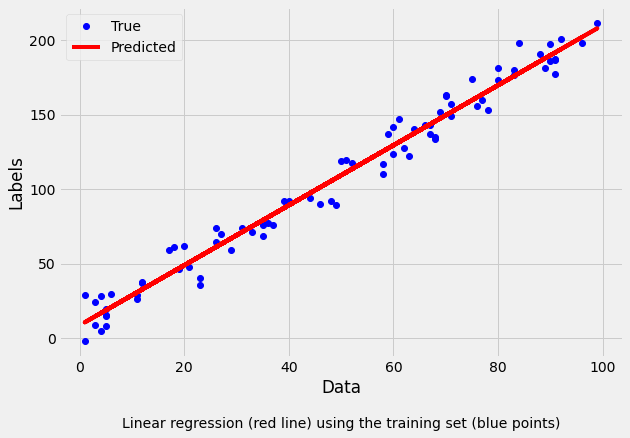

In [10]:
# Plot the regression over the train data:
LR = LinearRegression2D()
LR.train(data = train_data, labels = train_labels)
print("Regression coefficients: " + str((LR._beta0, LR._beta1)))
print("Performance metrics on test data: " + str(LR.evaluate(data = test_data, labels = test_labels)))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(train_data, train_labels, 'bo', label = "True")
ax.plot(train_data, LR.predict(data = train_data), label = "Predicted", color = "red")
ax.set_xlabel('Data')
ax.set_ylabel('Labels')
plt.legend(title = "")
label="Linear regression (red line) using the training set (blue points)"
ax.text((train_data.max()+train_data.min())/2, -60, label, ha='center')

plt.show()

**Running the model in a Federated configuration.**
After defining the data and the model, we are ready to run our model in a federated configuration. 
We distribute the data over the nodes, assuming the data is IID.
Next, we define the aggregation of the federated outputs to be the average. 
In this case, we set the number of rounds `n=1` since no iterations are needed in this specific case of 2D linear regression. 
It can be observed that the performance of *Federated Global model* is in general superior with respect to the performance of each node, thus the federated learning approach proves to be beneficial.
Moreover, the Federated Global model exhibits comparable performance to the centralized one (see previous cell).

In [4]:
# Create the IID data: 
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes = 12, percent=100)
print(type(federated_data))
print(federated_data.num_nodes())

# Define a model builder: 
def model_builder():
    model = LinearRegression2D()
    return model

# Run the algorithm:
aggregator = shfl.federated_aggregator.FedAvgAggregator()
federated_government = shfl.federated_government.FederatedGovernment(model_builder, federated_data, aggregator)

federated_government.run_rounds(n = 1, test_data = test_data, test_label = test_label)

<class 'shfl.private.federated_operation.FederatedData'>
12
Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f6a2470c198>: (12.239479421685854, 2.8500528762253654)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f6a2470c668>: (10.201934462059677, 1.1185269168260548)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f6a2471e4e0>: (11.215132251874945, 1.7944471992401916)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f6a2471ea58>: (10.766258478133407, 1.6000970022923675)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f6a2471e860>: (11.920814546209458, 1.7650402999700134)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f6a2471ea90>: (13.61175278351188, 4.301836052852871)
Test performance client <shfl.private.federated_operation.Fed

**Adding Differential Privacy: sampling model's sensitivity.** 
In the case of applying the Laplace privacy mechanism (see also [Laplace mechanism notebook](./differential_privacy_laplace.ipynb)), the noise added has to be of the order of the sensitivity of the model's output (the values of the intercept and slope in our 2D linear regression). 
In the general case, model's sensitivity might be difficult to compute analytically. 
An alternative approach is to attain *random* differential privacy through a sampling over the data (see [Rubinstein 2017](https://arxiv.org/pdf/1706.02562.pdf)). That is, instead of computing analytically the *global* sensitivity $\Delta f$, we compute an *empirical estimation* of it by sampling over the dataset.
The framework provides a method to sample the sensitivity (see the implementation [here](../shfl/differential_privacy/sensitivity_sampler.py)).

In order to carry out this approach, we need to specify a distribution of the data to sample from. 
This in general requires previous knowledge and/or model assumptions. 
However,  we may assume that the data distribution is *uniform* and avoid specific assumptions. 
To the end, we define our class of `ProbabilityDistribution` that uniformly samples over a data-frame.
Moreover, we assume that we do have access to a set of data (this can be thought, for example, as some reference public data set). 
In this example, we generate new data for sampling:

In [11]:
class UniformDistribution(shfl.differential_privacy.ProbabilityDistribution):
    """
    Implement Uniform Distribution over real data
    """
    def __init__(self, sample_data):
        self._sample_data = sample_data

    def sample(self, sample_size):
        row_indices = np.random.randint(low = 0, 
                                        high=self._sample_data.shape[0], 
                                        size=sample_size, 
                                        dtype='l')
        
        return self._sample_data[row_indices, :]
    
# Generate new data for sampling: 
data, labels = generate_data()
database = LabeledDatabase(data, labels)
data_sample, labels_sample, _, _ = database.load_data()
sample_data = np.zeros((len(data_sample), 2))
sample_data[:,0] = data_sample
sample_data[:,1] = labels_sample

The class `SensitivitySampler` implements the sampling given a *query* (which is the model itself in this case).
We only need to add the method `get` to our model since it is required by the class. 
We choose the sensitivity norm to be the $L_1$ norm and we apply the sampling. 
The value of the sensitivity depends on the number of samples `n`: the more samples we perform, the more accurate the sensitivity. 
Indeed, increasing the number of samples `n`, the sensitivity decreases, as shown below:

In [16]:
from shfl.differential_privacy import SensitivitySampler
from shfl.differential_privacy import L1SensitivityNorm

class LinearRegression2DSample(LinearRegression2D):
    
    def get(self, data_array):
        data = data_array[:, 0]
        labels = data_array[:, 1]
        train_model = self.train(data, labels)
        
        return np.asarray(self.get_model_params())

distribution = UniformDistribution(sample_data)
sampler = SensitivitySampler()

n_samples = 10
max_sensitivity, mean_sensitivity = sampler.sample_sensitivity(LinearRegression2DSample(), L1SensitivityNorm(), distribution, n=n_samples, gamma=0.05)
print("Sampled max sensitivity: " + str(max_sensitivity))
print("Sampled mean sensitivity: " + str(mean_sensitivity))

Sampled max sensitivity: 25.757471040939528
Sampled mean sensitivity: 2.36207049522593


In [18]:
n_samples = 200
max_sensitivity, mean_sensitivity = sampler.sample_sensitivity(LinearRegression2DSample(), L1SensitivityNorm(), distribution, n=n_samples, gamma=0.05)
print("Sampled max sensitivity: " + str(max_sensitivity))
print("Sampled mean sensitivity: " + str(mean_sensitivity))

Sampled max sensitivity: 0.6013982120547137
Sampled mean sensitivity: 0.10012353987265298


Unfortunately, sampling over a dataset involves, at each sample, the training of the model on two datasets differing in one entry.
Thus in general this procedure might be computationally expensive (e.g. in the case of training a deep neuronal network).

**Running the model in a Federated configuration with Differential Privacy.**
At this stage we are ready to add a layer of DP to our federated learning model. 
We will apply the Laplace mechanism, assuming the sensitivity of our model is the mean obtained from the previous sampling. 
The Laplace mechanism provided by the *Sherpa.FL* Framework is then assigned as the *private* access type to the model's parameters of each client in a new `FederatedGovernment` object. 
This results into an $\epsilon$-*differentially private FL model*.
For example, picking the value $\epsilon = 0.5$, we can run the FL experiment with DP:

In [ ]:
from shfl.differential_privacy import LaplaceMechanism

params_access_definition = LaplaceMechanism(sensitivity=mean_sensitivity, epsilon=0.5)
federated_governmentDP = shfl.federated_government.FederatedGovernment(
    model_builder, federated_data, aggregator, model_params_access=params_access_definition)

federated_governmentDP.run_rounds(n=1, test_data=test_data, test_label=test_labels)

In the above example we observed that the performance of the model has slightly deteriorated due to the addition of Differential Privacy. 
It must be noted that each run involves a different random noise added by the Differential Privacy mechanism.
However, in general, the privacy increases at expenses of accuracy (i.e. for smaller values of $\epsilon$).